### Problem 3. PyTorch tutorial and questions

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Example Code from Cifar10 Tutorial
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


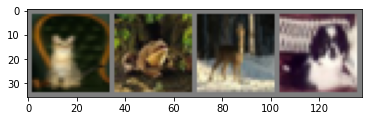

  cat  frog  deer   dog


In [25]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [29]:
net.to(device)
losses = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            losses.append(running_loss/2000)
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.229
[1,  4000] loss: 1.868
[1,  6000] loss: 1.675
[1,  8000] loss: 1.582
[1, 10000] loss: 1.542
[1, 12000] loss: 1.458
[2,  2000] loss: 1.389
[2,  4000] loss: 1.364
[2,  6000] loss: 1.344
[2,  8000] loss: 1.314
[2, 10000] loss: 1.281
[2, 12000] loss: 1.265
Finished Training


In [30]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### (ii) How many images and batches are used to train the network?

There 50000 images in the training set. Since each batch contains 4 images, the total number of batches is 50000/4 = 12500.

In [31]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

#### (iii) Do we normalize the images? What do we do in the example?
Yes, we normalize the images. In the example, the function "torchvision.transforms.ToTensor()" completes the normalization by doing : output = (input - mean) / std. It converts the PIL image with a pixel range of [0, 255] to a PyTorch FloatTensor of shape (C, H, W) with a range [0.0, 1.0]. 

#### (iv) The losses are dropping! Can you plot out the training loss?

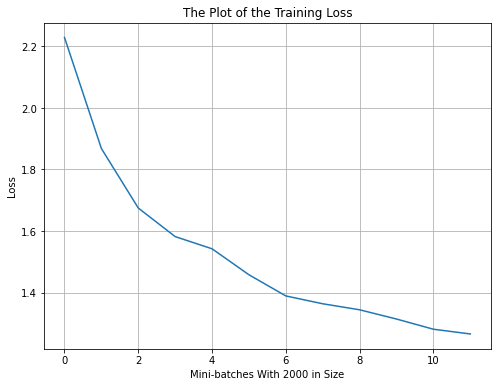

In [47]:
fig = plt.figure(figsize=(8,6))
plt.plot(losses)
plt.title('The Plot of the Training Loss')
plt.ylabel('Loss')
plt.xlabel('Mini-batches With 2000 in Size')
plt.grid(True)

#### Now the network is done training. Can you check some successful cases and some failure cases (show some images classified by the network)?


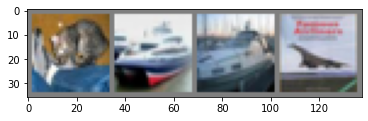

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship  ship  ship
The predictions of the 2nd and the 3rd images are correct, but the predictions of 1st and 4th images failed


In [53]:
dataiter = iter(testloader)
images, labels = dataiter.next()

net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('The predictions of the 2nd and the 3rd images are correct,',
      'but the predictions of 1st and 4th images failed')

In [54]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


In [55]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 55.1 %
Accuracy for class car   is: 76.5 %
Accuracy for class bird  is: 39.7 %
Accuracy for class cat   is: 48.3 %
Accuracy for class deer  is: 35.3 %
Accuracy for class dog   is: 45.1 %
Accuracy for class frog  is: 66.1 %
Accuracy for class horse is: 65.6 %
Accuracy for class ship  is: 75.0 %
Accuracy for class truck is: 64.4 %


#### (vi) Can you visualize the output of the 1st layer of CNN using one image from the training set?

In [58]:
class firstCNN(nn.Module):
    def __init__(self):
        super(firstCNN,self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
    def forward(self, x):
        x = self.conv1(x)
        return x

net_1stLayer = firstCNN().to(device)

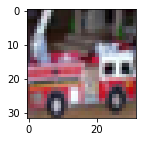

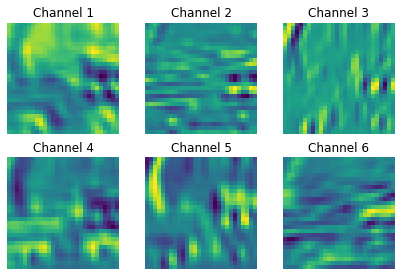

In [104]:
data = next(iter(trainloader))
inputs, labels = data[0].to(device), data[1].to(device)

outputs = net_1stLayer(inputs)

imgs_1st = outputs[0,:,:,:]

plt.figure(figsize=(2,2))
imshow(torchvision.utils.make_grid(inputs[0].cpu()))
plt.figure(figsize=(7,7))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs_1st[i].detach().cpu())
    plt.title('Channel %d' %(i+1))
    plt.axis('off')